In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

import os, sys

import utils

from train import train

# Preprocessing and import

In [2]:
ROOT_DIR = 'training/'
IMAGE_DIR = ROOT_DIR + 'images/'

In [3]:
def load_image(filename):
    return mpimg.imread(filename)

#def unstack(img):
#    return np.array([img[:,:,c] for c in range(3)])

#def restack(img):
#    return np.stack(img, axis=-1)

In [4]:
# Read images
files = os.listdir(IMAGE_DIR)
imgs = [load_image(IMAGE_DIR + file) for file in files] # images (400, 400, 3)

In [5]:
# Read groundtruts
GT_DIR = ROOT_DIR + 'groundtruth/'
gt_imgs = [load_image(GT_DIR + file) for file in files] # images (400, 400)

In [6]:
KERNEL_SIDE = 3

# Matrix creation

In [7]:
def image_to_features(img, kernel_size):
    """Linearizes patches of an image into lines.
    Arguments:
     :img: the image to linearize of shape (W, H, C)
     :kernel_size: the length of the side of the patch which will be squared
     should be odd.
    
    The radius of the patch is r = (kernel_size - 1) / 2
    The produced matrix has shape ((W - r)*(H - r), kernel_size**2 * C)
    """
    features = []
    for i in range(img.shape[0] - (kernel_size - 1)):
        for j in range(img.shape[1] - (kernel_size - 1)):
            features.append(np.ravel(img[i : i + kernel_size, j : j + kernel_size]))
    return np.vstack(features)

In [8]:
def reassemble(lines, kernel_size, original_w, original_h, channels=3):
    center_flat = v * kernel_size + v
    shifter = np.arange(lines.shape[0]) * lines.shape[1]
    shifter = np.reshape(shifter, (len(shifter), 1))
    shifter = np.tile(shifter, (1, channels))
    mask = np.array([center_flat * channels + i for i in range(channels)])
    mask = np.tile(mask, (lines.shape[0], 1))
    mask = shifter + mask
    mask = np.ravel(mask)
    flat = np.ravel(lines)
    pixels = flat[mask]
    return np.reshape(pixels, (original_w - (kernel_size - 1), original_h - (kernel_size - 1), channels))

In [9]:
def crop_groundtruth(img, kernel_size):
    radius = (kernel_size - 1) // 2
    img[img < 0.5] = -1
    img[img >= 0.5] = 1
    return img[radius : -radius, radius : -radius]

In [10]:
def preds_to_tensor(preds, kernel_size, n, w, h):
    return np.reshape(preds, (n, w - (kernel_size - 1), h - (kernel_size - 1)))

In [11]:
#features = np.vstack([image_to_features(img, 3) for img in imgs])
features = np.vstack([image_to_features(img, KERNEL_SIDE) for img in imgs[:1]])

In [12]:
#labels = [crop_groundtruth(gt, 3) for gt in gt_imgs]
labels = [crop_groundtruth(gt, KERNEL_SIDE) for gt in gt_imgs[:1]]

In [13]:
features.shape

(158404, 27)

In [14]:
labels = np.ravel(labels)

In [15]:
features.shape, labels.shape

((158404, 27), (158404,))

In [16]:
X = torch.from_numpy(features)
Y = torch.from_numpy(labels)

# Train

In [17]:
import funky

In [18]:
model = nn.Sequential(
    nn.Linear(KERNEL_SIDE**2 * 3, 12),
    nn.Sigmoid(),
    nn.Linear(12, 1),
)

In [19]:
lr = 0.02
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)#, momentum=0.9)

costf = torch.nn.MSELoss()

train(X, Y, model, costf, optimizer, 10000, 100)

Epoch [1/10000], Loss: 0.6279
Epoch [101/10000], Loss: 0.4789
Epoch [201/10000], Loss: 0.4675
Epoch [301/10000], Loss: 0.4517
Epoch [401/10000], Loss: 0.4385
Epoch [501/10000], Loss: 0.4255
Epoch [601/10000], Loss: 0.4161
Epoch [701/10000], Loss: 0.4123
Epoch [801/10000], Loss: 0.4075
Epoch [901/10000], Loss: 0.4053
Epoch [1001/10000], Loss: 0.4018
Epoch [1101/10000], Loss: 0.3992
Epoch [1201/10000], Loss: 0.3989
Epoch [1301/10000], Loss: 0.4280
Epoch [1401/10000], Loss: 0.3933
Epoch [1501/10000], Loss: 0.3922
Epoch [1601/10000], Loss: 0.3912
Epoch [1701/10000], Loss: 0.3903
Epoch [1801/10000], Loss: 0.3913
Epoch [1901/10000], Loss: 0.3893
Epoch [2001/10000], Loss: 0.3916
Epoch [2101/10000], Loss: 0.3891
Epoch [2201/10000], Loss: 0.3857
Epoch [2301/10000], Loss: 0.3844
Epoch [2401/10000], Loss: 0.3837
Epoch [2501/10000], Loss: 0.3831
Epoch [2601/10000], Loss: 0.3826
Epoch [2701/10000], Loss: 0.3821
Epoch [2801/10000], Loss: 0.3815
Epoch [2901/10000], Loss: 0.3811
Epoch [3001/10000], Lo

# Test on first image

In [76]:
img = imgs[0]
test_x = torch.from_numpy(image_to_features(img, KERNEL_SIDE))

In [77]:
preds = model(Variable(test_x))

In [78]:
preds = preds.data.numpy()

In [79]:
np.max(preds)

1.2321903

In [80]:
t = preds_to_tensor(preds, KERNEL_SIDE, 1, 400, 400)

In [81]:
t = t[0]

In [70]:
t[t < 0] = 0
t[t > 0 ] = 1

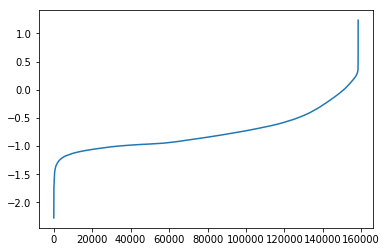

In [82]:
plt.plot(np.sort(t.ravel()))

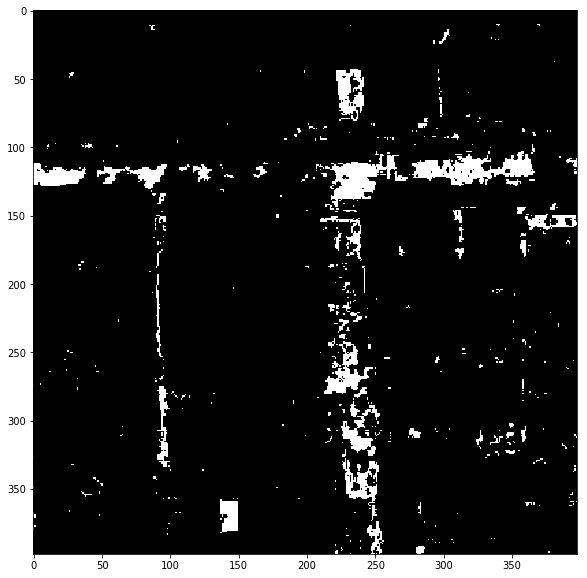

In [72]:
plt.figure(figsize=(10,10))
plt.imshow(t, cmap='Greys_r')

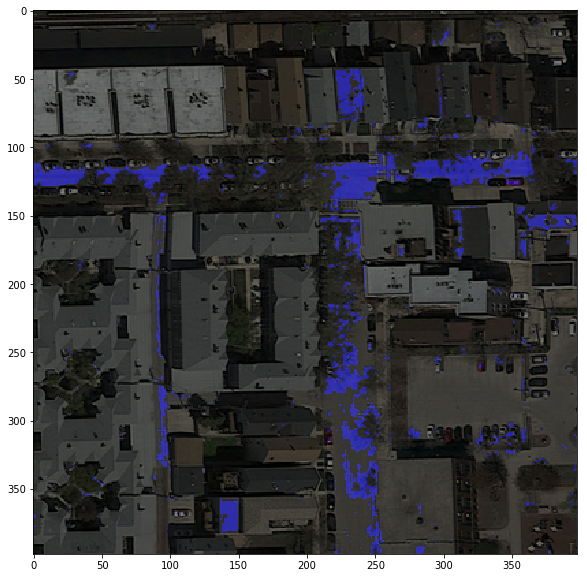

In [75]:
new_img = utils.make_img_overlay(img[1:-1, 1:-1], t)
plt.figure(figsize=(10,10))
plt.imshow(new_img)

# Old Shit

In [ ]:
# Build train tensor

#X = torch.from_numpy(np.stack(imgs))) # tensor (N, W, H, C)
X = torch.from_numpy(np.stack(imgs[:10]))

In [ ]:
lr = 0.2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
costf = torch.nn.MSELoss()

In [ ]:
# Build groundtruth tensor

#Y = torch.from_numpy(np.stack(gt_imgs))
Y = torch.from_numpy(np.stack(gt_imgs[:10]))

In [ ]:
train(X, Y, funky.model, costf, optimizer, 50)

In [ ]:
# Choose image to analyze
img = imgs[0]

In [ ]:
test_x.shape, X.shape

In [ ]:
# Predict and give correct shape
test_x = Variable(torch.from_numpy(img).unsqueeze(0))
preds = model(test_x).squeeze(0).data.numpy()

In [ ]:
plt.plot(np.sort(np.ravel(preds)))

In [ ]:
preds.max()

In [ ]:
# Draw
cimg = utils.concatenate_images(img, preds)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [ ]:
new_img = utils.make_img_overlay(img, preds)
plt.figure(figsize=(10,10))
plt.imshow(new_img)